In [1]:
import numpy as np
import torch.autograd
import time
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
import dgl
from graphenvs import HalfCheetahGraphEnv
import itertools
from mbrl.util.math import gaussian_nll
import seaborn as sns

%matplotlib widget

Running on the GPU


Using backend: pytorch


In [5]:
class Network(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_sizes,
        with_batch_norm=False,
        activation=None,
        probabilistic = False
    ):
        super(Network, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size
        self.output_size = output_size
        self.probabilistic = probabilistic
        self.hidden_layers = nn.ModuleList()

        self.hidden_layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        if with_batch_norm:
            self.hidden_layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[0])))
        self.hidden_layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            if with_batch_norm:
                self.hidden_layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[i+1])))
            self.hidden_layers.append(nn.ReLU())
        
        if probabilistic:
            self.output_size = self.output_size * 2
        self.final_layer = nn.Linear(hidden_sizes[len(hidden_sizes) - 1], self.output_size)
        
        self.final_activation = None
        if activation is not None:
            self.final_activation = activation()
            
    def forward(self, x):
        out = x
        
        for layer in self.hidden_layers:
            out = layer(out)
            
        out = self.final_layer(out)
            
        if self.final_activation:
            if self.probabilistic:
                out[:, :, 0] = self.final_activation(out[:, :, 0])

            else:
                out = self.final_activation(out)
        return out

In [6]:
class GraphNeuralNetwork(nn.Module):
    def __init__(
        self,
        inputNetwork,
        messageNetwork,
        updateNetwork,
        outputNetwork,
        num_message_passing_iterations,
        withInputNetwork = True
    ):
        
        super(GraphNeuralNetwork, self).__init__()
                
        self.inputNetwork = inputNetwork
        self.messageNetwork = messageNetwork
        self.updateNetwork = updateNetwork
        self.outputNetwork = outputNetwork
        
        self.num_message_passing_iterations = num_message_passing_iterations
        self.withInputNetwork = withInputNetwork
        
    def inputFunction(self, nodes):
        return {'state' : self.inputNetwork(nodes.data['input'])}
    
    def messageFunction(self, edges):
        
        batchSize = edges.src['state'].shape[1]
        edgeData = edges.data['feature'].repeat(batchSize, 1).T.unsqueeze(-1)
        nodeInput = edges.src['input']
        
        return {'m' : self.messageNetwork(torch.cat((edges.src['state'], edgeData, nodeInput), -1))}
    
    def updateFunction(self, nodes):
        return {'state': self.updateNetwork(torch.cat((nodes.data['m_hat'], nodes.data['state']), -1))}
    
    def outputFunction(self, nodes):
        
        return {'output': self.outputNetwork(nodes.data['state'])}


    def forward(self, graph, state):
        
        self.update_states_in_graph(graph, state)
        
        if self.withInputNetwork:
            graph.apply_nodes(self.inputFunction)
        
        for messagePassingIteration in range(self.num_message_passing_iterations):
            graph.update_all(self.messageFunction, dgl.function.mean('m', 'm_hat'), self.updateFunction)
        
        graph.apply_nodes(self.outputFunction)
        
        output = graph.ndata['output']
        output = torch.transpose(output, dim0=0, dim1=1).squeeze(-1)

        return output
    
    def update_states_in_graph(self, graph, state):
        if len(state.shape) == 1:
            state = state.unsqueeze(0)
        
        numGraphFeature = 6
        numGlobalStateInformation = 5
        numLocalStateInformation = 2
        numStateVar = state.shape[1] // 2
        globalInformation = torch.cat((state[:, 0:5], state[:, numStateVar:numStateVar+5]), -1)
        
        numNodes = (numStateVar - 5) // 2

        nodeData = torch.empty((numNodes, state.shape[0], numGraphFeature + 2 * numGlobalStateInformation + 2 * numLocalStateInformation)).to(device)
        for nodeIdx in range(numNodes):

            # Assign global features from graph
            nodeData[nodeIdx, :, :6] = graph.ndata['feature'][nodeIdx]
            # Assign local state information
            nodeData[nodeIdx, :, 16] = state[:, 5 + nodeIdx]
            nodeData[nodeIdx, :, 17] = state[:, 5 + numNodes + nodeIdx]
            nodeData[nodeIdx, :, 18] = state[:, numStateVar + 5 + nodeIdx]
            nodeData[nodeIdx, :, 19] = state[:, numStateVar + 5 + numNodes + nodeIdx]

        # Assdign global state information
        nodeData[:, :, 6:16] = globalInformation
        
        if self.withInputNetwork:
            graph.ndata['input'] = nodeData        
        
        else:
            graph.ndata['state'] = nodeData


In [9]:
trainingIdxs = [4]

In [10]:
states = {}
actions = {}
rewards = {}
next_states = {}
dones = {}
env = {}

for morphIdx in trainingIdxs:

    prefix = '../datasets-old-run/{}/'.format(morphIdx)
    
    states[morphIdx] = np.load(prefix + 'states_array.npy')
    actions[morphIdx] = np.load(prefix + 'actions_array.npy')
    rewards[morphIdx] = np.load(prefix + 'rewards_array.npy')
    next_states[morphIdx] = np.load(prefix + 'next_states_array.npy')
    dones[morphIdx] = np.load(prefix + 'dones_array.npy')
    
    env[morphIdx] = HalfCheetahGraphEnv(None)
    env[morphIdx].set_morphology(morphIdx)

None
*************************************************************************************************************


NoneType: None


In [6]:
def save_weights_and_graph(save_dir):

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    torch.save(gnn.state_dict(), save_dir + 'gnn.pt')

    for morphIdx in trainingIdxs:

        trainingLosses = np.stack(actionTrainLosses[morphIdx])
        testingLosses = np.stack(actionTestLosses[morphIdx])

        np.save(save_dir + str(morphIdx) + '-actionTrainLosses.npy', trainingLosses)
        np.save(save_dir + str(morphIdx) + '-actionTestLosses.npy', testingLosses)

        try:
            plt.close(fig)
        except:
            pass

        fig = plt.figure()

        num_epochs = testingLosses.shape[0]
        num_batches_per_epoch = trainingLosses.shape[0] // num_epochs
        trainingLosses = trainingLosses.reshape(num_epochs, num_batches_per_epoch, trainingLosses.shape[1])
        trainingLosses = trainingLosses.mean(1)

        for node in range(trainingLosses.shape[1]):
            plt.plot(np.arange(trainingLosses.shape[0]), np.log10(trainingLosses[:, node]), c='blue')
            plt.plot(np.arange(trainingLosses.shape[0]), np.log10(testingLosses[:, node]), c='red')
            plt.legend(['Training', 'Testing'])
        fig.savefig(save_dir + str(morphIdx) + 'losses-graph.png')

In [11]:
X_test = {}
X_train = {}
Y_test = {}
Y_train = {}

for morphIdx in trainingIdxs:
    X = torch.from_numpy(states[morphIdx]).repeat(1, 2).to(torch.float32)
    X[:, X.shape[1] // 2:] -= next_states[morphIdx]
    Y = torch.from_numpy(actions[morphIdx]).to(torch.float32)
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    X_test[morphIdx] = X[:100000]
    X_train[morphIdx] = X[100000:]
    Y = Y[permutation]
    Y_test[morphIdx] = Y[:100000]
    Y_train[morphIdx] = Y[100000:]

In [13]:
hidden_sizes = [256, 256]

inputSize = 20
stateSize = 64
messageSize = 64
outputSize = 1
num_message_passing_iterations = 6
batch_size = 1024
with_batch_norm = True
num_batches_per_training_step = 1
num_networks = 1

numTrainingBatches = int(np.ceil(X_train[trainingIdxs[0]].shape[0] / batch_size))
numTestingBatches = int(np.ceil(X_test[trainingIdxs[0]].shape[0] / batch_size))

save_dir = "../models/new/inverseDynamics-single/4/attempt-1/"

all_networks = nn.ModuleDict()
optimizers = []
lr = 1e-4
weight_decay = 0
for i in range(num_networks):
    all_networks['input' + str(i)] = Network(inputSize, stateSize, hidden_sizes, with_batch_norm)
    all_networks['message' + str(i)] = Network(stateSize + inputSize + 1, messageSize, hidden_sizes, with_batch_norm, nn.Tanh)
    all_networks['update' + str(i)] = Network(stateSize + messageSize, stateSize, hidden_sizes, with_batch_norm)
    all_networks['output' + str(i)] = Network(stateSize, outputSize, hidden_sizes, with_batch_norm, nn.Tanh, probabilistic=True)

    all_networks['gnn' + str(i)] = GraphNeuralNetwork(all_networks['input' + str(i)], all_networks['message' + str(i)], all_networks['update' + str(i)], all_networks['output' + str(i)], num_message_passing_iterations).to(device)
    optimizers.append(optim.Adam(all_networks['gnn' + str(i)].parameters(), lr=lr, weight_decay=weight_decay))
    
l2Loss = nn.MSELoss(reduction='none')

In [9]:
# for network_idx in range(num_networks):
#     print(all_networks['gnn' + str(network_idx)].load_state_dict(torch.load('gnn' + str(network_idx))))

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>


In [14]:
testLosses = {}
trainLosses = {}

for network_idx in range(num_networks):
    trainLosses[network_idx] = []
    testLosses[network_idx] = []

In [15]:
for epoch in range(50):
    
    print('Starting Epoch {}'.format(epoch))
    epoch_t0 = time.time()
    
    with torch.no_grad():
        for network_idx in range(num_networks):
            numNodes = ((X_train[morphIdx].shape[1] // 2) - 5) // 2
            
            testLosses[network_idx].append(torch.zeros(numNodes))
            
            for batch_ in range(numTestingBatches):
                
                g = env[morphIdx].get_graph()._get_dgl_graph()
                                
                x = X_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                y = Y_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                
                pred_mean_and_logvar = all_networks['gnn' + str(network_idx)](g, x)
#                 actionsLoss = gaussian_nll(pred_mean_and_logvar[:, :, 0], pred_mean_and_logvar[:, :, 1], y)
#                 actionsLoss = l2Loss(pred_mean_and_logvar[:, :, 0], y)
                testLosses[network_idx][-1] += (pred_mean_and_logvar[:, :, 0] - y).abs().mean(0).cpu()

            testLosses[network_idx][-1] /= numTestingBatches
        
    for network_idx in range(num_networks):
        print('Test Network {} | Actions Loss {} \n'.format(
            morphIdx, np.round(testLosses[network_idx][-1], decimals=3)))


    for batch in range(0, numTrainingBatches, num_batches_per_training_step):
                
        t0 = time.time()
        
        for network_idx in range(num_networks):
            numNodes = ((X_train[morphIdx].shape[1] // 2) - 5) // 2
            trainLosses[network_idx].append(torch.zeros(numNodes))
            optimizers[network_idx].zero_grad()
        
        for batchOffset in range(num_batches_per_training_step):

            if batch + batchOffset >= numTrainingBatches - 1:
                break
                
            for network_idx in range(num_networks):
                
                g = env[morphIdx].get_graph()._get_dgl_graph()
                
                batch_indeces = np.random.choice(X_train[morphIdx].size(0), batch_size)
                x = X_train[morphIdx][batch_indeces].to(device)
                y = Y_train[morphIdx][batch_indeces].to(device)
                
                pred_mean_and_logvar = all_networks['gnn' + str(network_idx)](g, x)
                actionsLoss = gaussian_nll(pred_mean_and_logvar[:, :, 0], pred_mean_and_logvar[:, :, 1], y)
#                 actionsLoss = l2Loss(pred_mean_and_logvar[:, :, 0], y)

                trainLosses[network_idx][-1] += (pred_mean_and_logvar[:, :, 0] - y).abs().mean(0).cpu().detach() / num_batches_per_training_step

                actionsLoss = actionsLoss.mean() / num_batches_per_training_step
                actionsLoss.backward()
        
        for network_idx in range(num_networks):
            optimizers[network_idx].step()
        
        if batch % 100 == 0:
            print('Batch {} in {}s'.format(batch, np.round(time.time() - t0, decimals=1)))
            for network_idx in range(num_networks):
                print('Train Network {} | Actions Loss {} \n'.format(
                    network_idx, np.round(trainLosses[network_idx][-1], decimals=3)))

        t_final = time.time() - t0
    print('Epoch {} finished in {}'.format(epoch, np.round(time.time() - epoch_t0, decimals=1)))


Starting Epoch 0
Test Network 4 | Actions Loss tensor([0.8470, 0.8840, 0.9230, 0.8270, 0.8440, 0.8170, 0.8730]) 

Batch 0 in 0.1s
Train Network 0 | Actions Loss tensor([0.8410, 0.8790, 0.9260, 0.8200, 0.8390, 0.8120, 0.8770]) 

Batch 100 in 0.1s
Train Network 0 | Actions Loss tensor([0.3010, 0.1930, 0.1750, 0.1210, 0.2770, 0.1160, 0.1490]) 

Batch 200 in 0.1s
Train Network 0 | Actions Loss tensor([0.2740, 0.1870, 0.1650, 0.1160, 0.2380, 0.1180, 0.1520]) 

Batch 300 in 0.1s
Train Network 0 | Actions Loss tensor([0.2560, 0.1790, 0.1460, 0.1170, 0.2160, 0.1210, 0.1570]) 

Batch 400 in 0.1s
Train Network 0 | Actions Loss tensor([0.2380, 0.1700, 0.1400, 0.1190, 0.2070, 0.1110, 0.1520]) 

Batch 500 in 0.1s
Train Network 0 | Actions Loss tensor([0.2070, 0.1590, 0.1400, 0.1150, 0.2200, 0.1140, 0.1490]) 

Batch 600 in 0.1s
Train Network 0 | Actions Loss tensor([0.2200, 0.1490, 0.1410, 0.1160, 0.1850, 0.1140, 0.1500]) 

Batch 700 in 0.1s
Train Network 0 | Actions Loss tensor([0.2340, 0.1640, 0.1

In [18]:
for network_idx in range(num_networks):
    torch.save(all_networks['gnn' + str(network_idx)].state_dict(), save_dir + 'de' + str(network_idx))

In [19]:
testPredictions = torch.empty((num_networks+1, Y_test[morphIdx].size(0), Y_test[morphIdx].size(1)))
with torch.no_grad():
    for network_idx in range(num_networks):
        numNodes = ((X_train[morphIdx].shape[1] // 2) - 5) // 2

        for batch_ in range(numTestingBatches):

            g = env[morphIdx].get_graph()._get_dgl_graph()

            x = X_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
            y = Y_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)

            pred_mean_and_logvar = all_networks['gnn' + str(network_idx)](g, x)
#                 actionsLoss = gaussian_nll(pred_mean_and_logvar[:, :, 0], pred_mean_and_logvar[:, :, 1], y)
#                 actionsLoss = l2Loss(pred_mean_and_logvar[:, :, 0], y)
            testPredictions[network_idx, batch_ * batch_size:(batch_+1)*batch_size, :] = pred_mean_and_logvar[:, :, 0]
testPredictions[num_networks] = testPredictions[:-1].mean(0)

In [29]:
differences = list(np.log10((testPredictions - Y_test[morphIdx]).abs() + 1e-6).cpu().numpy()[0].T)

In [28]:
differences.shape

(7, 100000)

In [33]:
fig = plt.figure()
sns.boxplot(data=list(differences))
fig.savefig(save_dir + 'l1-losses-per-node.png')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
for epoch in range(50):
    
    print('Starting Epoch {}'.format(epoch))
    epoch_t0 = time.time()
    
    for morphIdx in trainingIdxs:
        permutation = np.random.permutation(X_train[morphIdx].shape[0])
        X_train[morphIdx] = X_train[morphIdx][permutation]
        Y_train[morphIdx] = Y_train[morphIdx][permutation]

    with torch.no_grad():
        
        for network_index in range(num_networks):
            for morphIdx in trainingIdxs:
                numNodes = ((X_train[morphIdx].shape[1] // 2) - 5) // 2
                actionTestLosses[morphIdx].append(torch.zeros(numNodes))
                for batch_ in range(numTestingBatches):

                    g = env[morphIdx].get_graph()._get_dgl_graph()

                    x = X_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                    y = Y_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)

                    pred_mean_and_logvar = gnn(g, x)
    #                 actionsLoss = gaussian_nll(pred_mean_and_logvar[:, :, 0], pred_mean_and_logvar[:, :, 1], y)
    #                 actionsLoss = l2Loss(pred_mean_and_logvar[:, :, 0], y)
                    actionTestLosses[morphIdx][-1] += (pred_mean_and_logvar[:, :, 0] - y).abs().mean(0).cpu()

                actionTestLosses[morphIdx][-1] /= numTestingBatches
    s = 0
    for morphIdx in trainingIdxs:
        print('Test Idx {} | Actions Loss {} \n'.format(
            morphIdx, np.round(actionTestLosses[morphIdx][-1], decimals=3)))
        s += actionTestLosses[morphIdx][-1].mean()

    lr_scheduler.step(s)

    for batch in range(0, numTrainingBatches, num_batches_per_training_step):
                
        t0 = time.time()
        
        for morphIdx in trainingIdxs:
            numNodes = ((X_train[morphIdx].shape[1] // 2) - 5) // 2
            actionTrainLosses[morphIdx].append(torch.zeros(numNodes))

        optimizer.zero_grad()
        
        for batchOffset in range(num_batches_per_training_step):

            if batch + batchOffset >= numTrainingBatches - 1:
                break
                
            for morphIdx in trainingIdxs:
                
                g = env[morphIdx].get_graph()._get_dgl_graph()
                                
                x = X_train[morphIdx][(batch+batchOffset) * batch_size:(batch+batchOffset+1)*batch_size].to(device)
                y = Y_train[morphIdx][(batch+batchOffset) * batch_size:(batch+batchOffset+1)*batch_size].to(device)
                
                pred_mean_and_logvar = gnn(g, x)
                actionsLoss = gaussian_nll(pred_mean_and_logvar[:, :, 0], pred_mean_and_logvar[:, :, 1], y)
#                 actionsLoss = l2Loss(pred_mean_and_logvar[:, :, 0], y)

                actionTrainLosses[morphIdx][-1] += (pred_mean_and_logvar[:, :, 0] - y).abs().mean(0).cpu().detach() / num_batches_per_training_step

                actionsLoss = actionsLoss.mean() / num_batches_per_training_step
                actionsLoss.backward()

        optimizer.step()        
        
        if batch % 100 == 0:
            print('Batch {} in {}s'.format(batch, np.round(time.time() - t0, decimals=1)))
            for morphIdx in trainingIdxs:
                print('Train Idx {} | Actions Loss {} \n'.format(
                    morphIdx, np.round(actionTrainLosses[morphIdx][-1], decimals=3)))

        t_final = time.time() - t0
    print('Epoch {} finished in {}'.format(epoch, np.round(time.time() - epoch_t0, decimals=1)))


In [ ]:
Test Idx 5 | Actions Loss tensor([0.1070, 0.1020, 0.1030, 0.0850, 0.0910, 0.1110, 0.1000]) 

In [83]:
# Cell for producing Per Node Loss for each Morphology

for morphIdx in range(7):
    if morphIdx in trainingIdxs:
        lossArr = torch.stack(testLosses[morphIdx]).T
        np.save('per-node-lossArr-{}'.format(morphIdx), lossArr)
        lossArr = np.log10(lossArr)
    else:
        lossArr = torch.stack(validLosses[morphIdx]).T
    fig, ax = plt.subplots(1, sharex=True)
    for i in range(lossArr.shape[0]):
        ax.plot(range(lossArr.shape[1]), lossArr[i])
    plt.legend(range(lossArr.shape[0]))
    plt.xlabel('Epoch')
    plt.grid()
    plt.ylabel('L2 Loss')
    plt.title('Per Node Testing Set Loss Morphology {}'.format(morphIdx, morphIdx in trainingIdxs))
    plt.savefig('per-node-loss-{}.jpg'.format(morphIdx))
    plt.show()
    

KeyError: 0

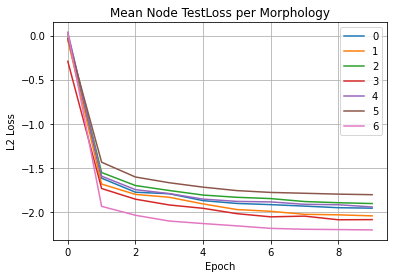

In [20]:
fig, ax = plt.subplots(1, sharex=True)
for morphIdx in trainingIdxs:
    lossArr = np.log10(torch.stack(testLosses[morphIdx]).mean(dim=1))
    ax.plot(range(lossArr.shape[0]), lossArr)
for morphIdx in validationIdxs:
    lossArr = torch.stack(validLosses[morphIdx]).mean(dim=1)
    ax.plot(range(lossArr.shape[0]), lossArr)

plt.xlabel('Epoch')
plt.ylabel('L2 Loss')
plt.title('Mean Node TestLoss per Morphology')
plt.grid(True)
plt.legend(trainingIdxs + validationIdxs)
plt.savefig('mean-node-losses.jpg')
plt.show()

In [23]:
torch.save(gnn.state_dict(), 'inverseModel-GNN.pt')

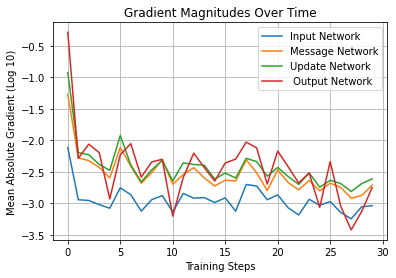

In [22]:
fig, ax = plt.subplots(1, sharex=True)
ax.plot(range(len(inputNetworkGradients)), np.log10(inputNetworkGradients))
ax.plot(range(len(messageNetworkGradients)), np.log10(messageNetworkGradients))
ax.plot(range(len(updateNetworkGradients)), np.log10(updateNetworkGradients))
ax.plot(range(len(outputNetworkGradients)), np.log10(outputNetworkGradients))
plt.xlabel('Training Steps')
plt.ylabel('Mean Absolute Gradient (Log 10)')
plt.title('Gradient Magnitudes Over Time')
plt.grid(True)
plt.legend(['Input Network', 'Message Network', 'Update Network', ' Output Network'])
plt.savefig('gradients.jpg')
plt.show()

In [55]:
a = np.random.normal(0, 0.25, size=(10000, 7))

In [56]:
np.abs(a).mean(-1)

array([0.17618861, 0.11729273, 0.24315307, ..., 0.14980191, 0.17725976,
       0.11425619])